# Beer Production Forecast

basic forecast training of beer production


data source: https://www.kaggle.com/shenba/time-series-datasets?select=monthly-beer-production-in-austr.csv

## imports

In [51]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as plx

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [52]:
db = pd.read_csv('./datasets/monthly-beer-production-in-austr.csv', parse_dates=True) #, index_col='Month'

## eda

In [53]:
db.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [54]:
db = db.rename(columns = {'Month': 'month', 'Monthly beer production': 'production'})

In [55]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   month       476 non-null    object 
 1   production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [56]:
db['month'] = pd.to_datetime(db['month'])

In [57]:
db.month.min(), db.month.max()
# db.index.min(), db.index.max()

(Timestamp('1956-01-01 00:00:00'), Timestamp('1995-08-01 00:00:00'))

In [58]:
db.isna().sum()

month         0
production    0
dtype: int64

In [59]:
plx.line(db, y='production')

In [60]:
db_forecast = db.set_index('month') #.to_period('M')

In [61]:
db_forecast

,production
month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0


<Figure size 1800x720 with 0 Axes>

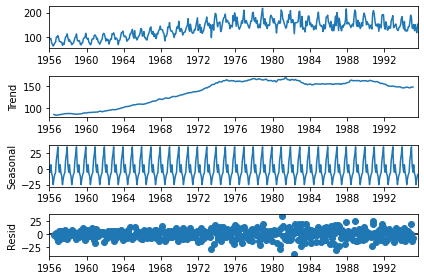

In [88]:
# checking seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(db_forecast) #, freq='m')

fig = plt.figure(figsize=(25, 10))  
fig = resultado.plot()

In [63]:
# Teste de estacionariedade. 
# p-value < 0,05 = estacionária
# p-value > 0,05 = não estacionária

from statsmodels.tsa.stattools import adfuller

result=adfuller(db_forecast['production'].dropna())

print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-2.282661418787566
p-valor:0.17762099829132877


## arima

### in sample forecast

In [64]:
# Auto ARIMA nos ajuda a buscar os melhores parâmetros
fit_arima = auto_arima(db_forecast['production'], d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                       seasonal=True,
                       m=6, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2, information_criterion='aic',
                       trace=True, error_action='ignore', stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=3667.083, Time=2.51 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=4549.066, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=3909.258, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=0.91 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=inf, Time=1.55 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=3687.775, Time=2.20 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=inf, Time=4.26 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=3536.571, Time=4.51 sec
 ARIMA(1,1,1)(0,1,2)[6]             : AIC=3958.026, Time=4.29 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=3521.625, Time=5.84 sec
 ARIMA(0,1,1)(2,1,2)[6]             : AIC=inf, Time=5.89 sec
 ARIMA(1,1,0)(2,1,2)[6]             : AIC=inf, Time=5.03 sec
 ARIMA(2,1,1)(2,1,2)[6]             : AIC=3509.219, Time=6.38 sec
 ARIMA(2,1,1)(1,1,2)[6]             : AIC=3518.879, Time=6.54 sec
 ARIMA(2,1,1)(2,1,1)[6]             : AIC=inf, Time=6.67 s

In [65]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(db_forecast['production'], order=(2,1,1),  seasonal_order=(2, 1, 2, 6))
resultado_sarimax = model.fit()

/home/alysson/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/alysson/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/alysson/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [66]:
# Vamos realizar um "backtesting" com predições de valores dos 12 meses anteriores

predicoes = resultado_sarimax.get_prediction(start=-12)
predicao_media = predicoes.predicted_mean

In [67]:
predicao_media

1994-09-01    136.677771
1994-10-01    158.846303
1994-11-01    174.903606
1994-12-01    184.359553
1995-01-01    145.249213
1995-02-01    139.732133
1995-03-01    155.854414
1995-04-01    137.478277
1995-05-01    134.990488
1995-06-01    121.401627
1995-07-01    128.274735
1995-08-01    138.636180
Freq: MS, Name: predicted_mean, dtype: float64

In [68]:
# intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

(117.71130263373769, 155.64423910097756)

In [69]:
# datas_previsao = np.asarray(predicao_media.index.astype(str))
# datas = np.asarray(db_forecast.index.astype(str))

datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(db_forecast.index)

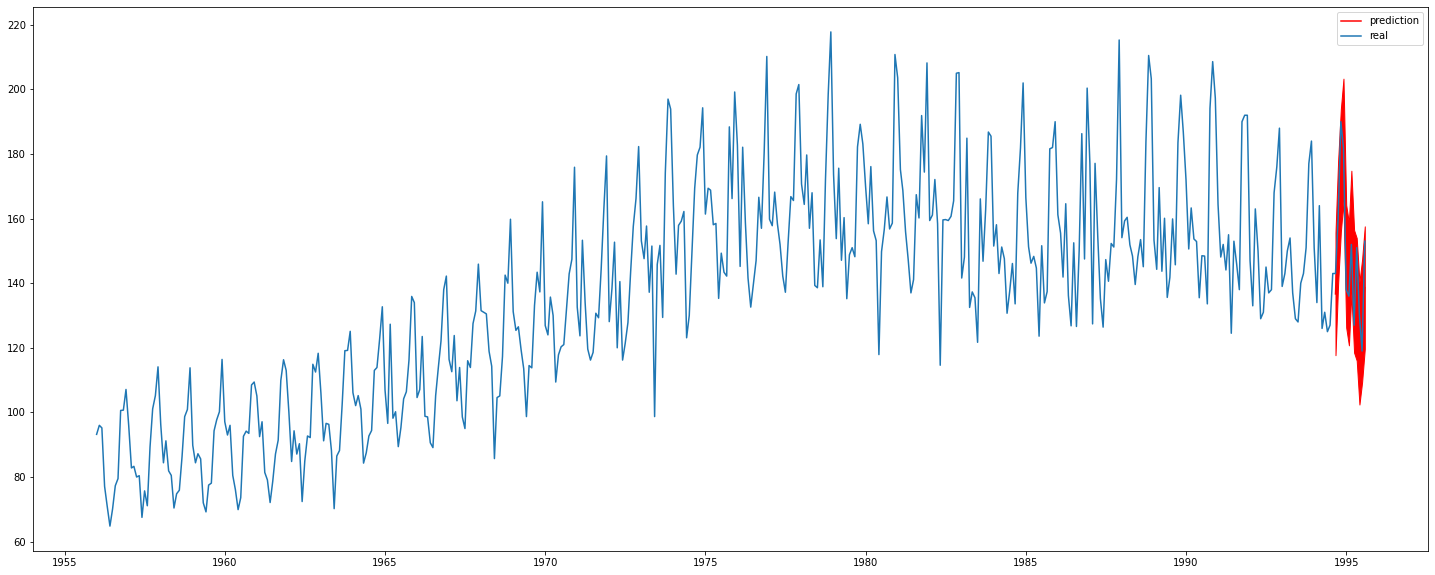

In [85]:
plt.figure(figsize=(25, 10))
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='red')
plt.plot(datas_previsao, predicao_media.values, color='red', label='prediction')
plt.plot(datas, db_forecast.values, label='real')
plt.legend()
plt.show()


# plt.plot(row.index, row.values)
# plt.show()

In [73]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(db_forecast[-12:].values, predicao_media.values))
print(rmse_sarima)

9.523993597682383


### out of sample forecast

In [74]:
# Forecast pra 12 values

forecast = resultado_sarimax.get_forecast(steps=12)
forecast_medio = forecast.predicted_mean

In [75]:
forecast_medio

1995-09-01    136.926105
1995-10-01    159.999101
1995-11-01    182.848627
1995-12-01    186.112955
1996-01-01    144.158977
1996-02-01    139.080823
1996-03-01    153.234190
1996-04-01    136.475177
1996-05-01    136.744692
1996-06-01    125.134626
1996-07-01    131.296406
1996-08-01    141.727532
Freq: MS, Name: predicted_mean, dtype: float64

In [76]:
intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

intervalo_abaixo_f[10], intervalo_acima_f[10]

(110.90042258195653, 151.69239000488818)

In [81]:
datas_forecast = np.asarray(forecast_medio.index) #.map(str))
pred_dates = np.asarray(predicao_media.index) #.map(str))

# df.index = df.index.map(str)

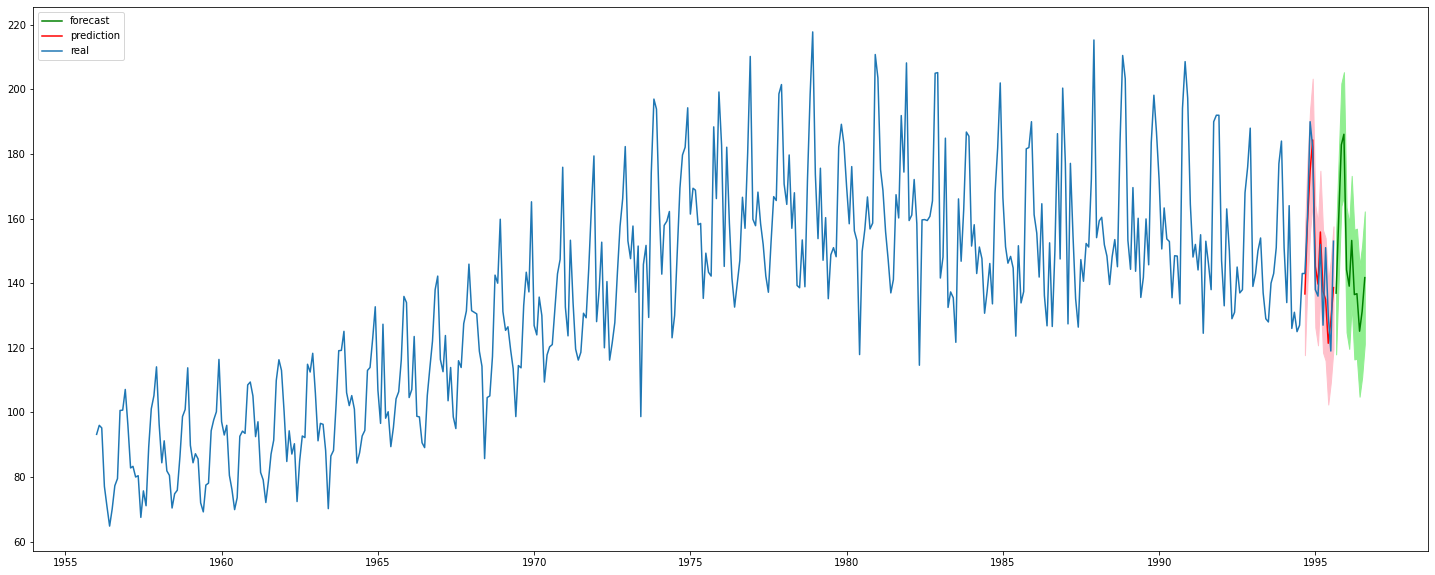

In [84]:
dates = np.asarray(db_forecast.index) #.map(str))

plt.figure(figsize=(25,10))
plt.plot(datas_forecast, forecast_medio.values, color='green', label='forecast')
plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color='lightgreen')

plt.plot(pred_dates, predicao_media.values, color='red', label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='pink')

plt.plot(dates, db_forecast.values, label='real')
plt.legend(loc='upper left')
plt.show()